<a href="https://colab.research.google.com/github/codeslayed/neural-network-visualisation/blob/main/mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. Loading and Preprocessing MNIST data (using first 5000 samples)...
   Training set size used: 5000 samples.
   Training set shape: X=(784, 5000), Y=(10, 5000)
2. Data loaded directly from library.

--- BASELINE MODEL (3-Layer, 1 Hidden Layer, Bias) ---
   Initialization: 2 layers. Bias: True.
   Starting training with LR=0.05, Epochs=400...
      Iter    0 | Cost: 2.4223 | Accuracy: 13.00%
      Iter  100 | Cost: 0.6216 | Accuracy: 85.26%
      Iter  200 | Cost: 0.4271 | Accuracy: 89.48%
      Iter  300 | Cost: 0.3560 | Accuracy: 90.90%
   Training finished in 22.81 seconds.
   Final Accuracy: 91.80%

--- EXPERIMENT 1: NO BIAS NODE ---
   Initialization: 2 layers. Bias: False.
   Starting training with LR=0.05, Epochs=400...
      Iter    0 | Cost: 2.4562 | Accuracy: 8.58%
      Iter  100 | Cost: 0.6526 | Accuracy: 85.22%
      Iter  200 | Cost: 0.4411 | Accuracy: 89.00%
      Iter  300 | Cost: 0.3666 | Accuracy: 90.44%
   Training finished in 21.71 seconds.
   Final Accuracy: 91.30

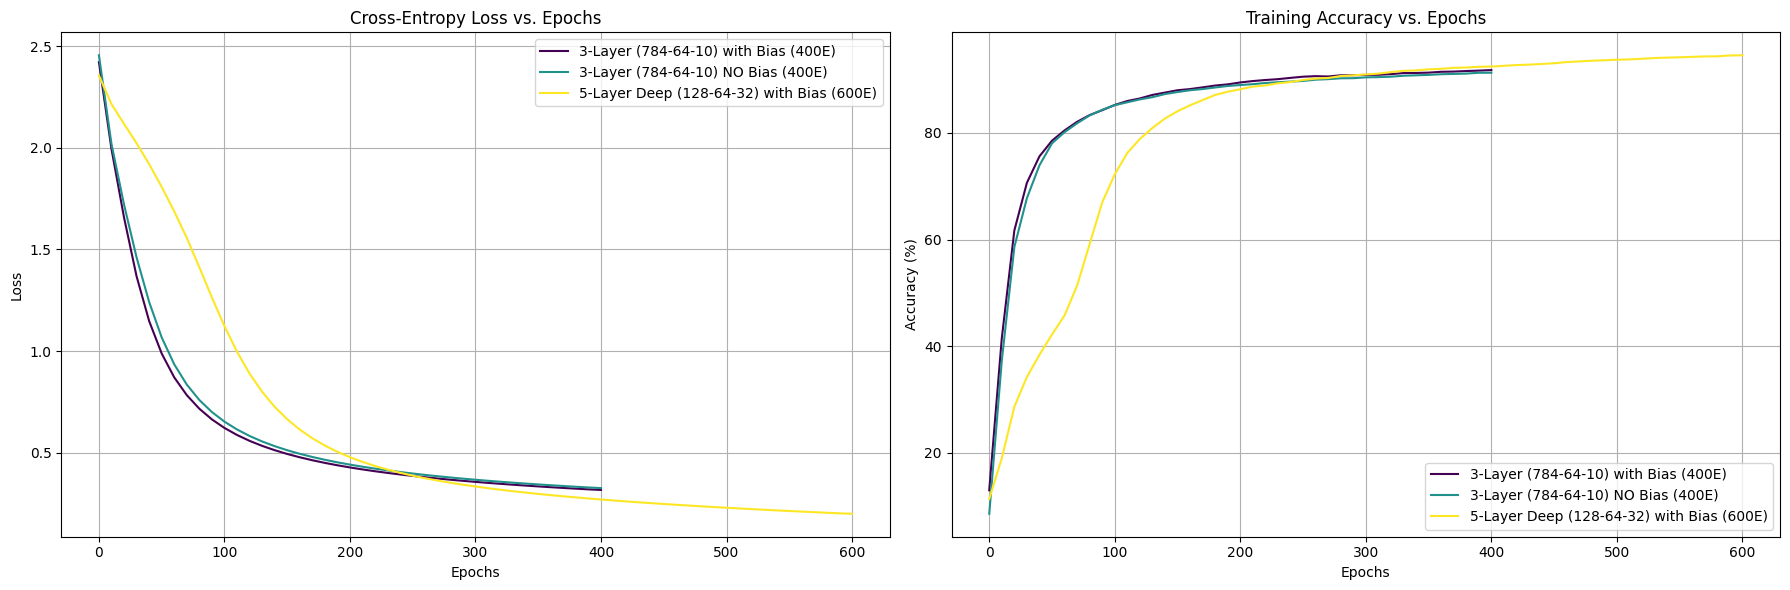

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.datasets import fetch_openml

# --- 1. Reading the MNIST Dataset from Library & 2. Dumping/Loading ---

def one_hot_encode(Y):
    """Converts a label vector (0-9) into a one-hot encoded matrix."""
    m = Y.shape[1]
    one_hot_Y = np.zeros((10, m))
    one_hot_Y[Y.astype(int), np.arange(m)] = 1
    return one_hot_Y

def get_mnist_data(sample_limit=5000):
    """
    Loads and preprocesses a *subset* of the MNIST training dataset
    to significantly speed up training time.
    """
    print(f"1. Loading and Preprocessing MNIST data (using first {sample_limit} samples)...")

    try:
        X_data, Y_data = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    except Exception as e:
        print(f"ERROR: Failed to load data from OpenML. Check if scikit-learn is installed and accessible: {e}")
        return None, None

    # --- OPTIMIZATION FOR SPEED: Use only the first 'sample_limit' instances ---
    X_train_orig = X_data[:sample_limit, :]
    Y_train_orig_str = Y_data[:sample_limit]

    m_train = X_train_orig.shape[0]

    # Reshape and Normalize images: (samples, pixels) -> (pixels, samples) / 255.
    X_train = X_train_orig.T / 255.

    # Convert string labels to integers and reshape: (m,) -> (1, m)
    Y_train_labels = Y_train_orig_str.astype(np.float64).reshape(1, m_train)

    # One-hot encode the labels (10 classes)
    Y_train = one_hot_encode(Y_train_labels)

    print(f"   Training set size used: {m_train} samples.")
    print(f"   Training set shape: X={X_train.shape}, Y={Y_train.shape}")
    print("2. Data loaded directly from library.")
    return X_train, Y_train


# --- 3. Defining the Architecture / Deep Neural Network Class ---

class DeepNeuralNetwork:
    """A customizable Deep Neural Network for MNIST classification."""

    def __init__(self, layer_dims, use_bias=True):
        """Initializes parameters based on layer dimensions."""
        self.layer_dims = layer_dims
        self.L = len(layer_dims) - 1
        self.use_bias = use_bias
        self.parameters = self._initialize_parameters()
        self.costs = []
        self.accuracies = []

    def _initialize_parameters(self):
        """Initializes W using He/Kaiming initialization and b as zeros."""
        parameters = {}
        print(f"   Initialization: {len(self.layer_dims)-1} layers. Bias: {self.use_bias}.")
        for l in range(1, self.L + 1):
            # He initialization: sqrt(2/input_dim)
            parameters['W' + str(l)] = np.random.randn(
                self.layer_dims[l], self.layer_dims[l-1]) * np.sqrt(2 / self.layer_dims[l-1])
            # Bias initialization
            if self.use_bias:
                 parameters['b' + str(l)] = np.zeros((self.layer_dims[l], 1))
        return parameters

    # --- Activation Functions ---
    def relu(self, Z):
        return np.maximum(0, Z)

    def softmax(self, Z):
        """Numerically stable Softmax for the output layer."""
        # Subtract max(Z) to prevent overflow during exponentiation
        exp_Z = np.exp(Z - np.max(Z, axis=0, keepdims=True))
        A = exp_Z / np.sum(exp_Z, axis=0, keepdims=True)
        return A

    # --- Forward Propagation ---
    def forward_propagation(self, X):
        """Performs forward pass through the network."""
        caches = []
        A = X

        # Hidden Layers: LINEAR -> ReLU
        for l in range(1, self.L):
            W = self.parameters['W' + str(l)]
            b = self.parameters.get('b' + str(l), 0)
            Z = np.dot(W, A) + b
            A_prev = A
            A = self.relu(Z)
            caches.append(((A_prev, W, b), Z))

        # Output Layer: LINEAR -> Softmax
        W = self.parameters['W' + str(self.L)]
        b = self.parameters.get('b' + str(self.L), 0)
        Z = np.dot(W, A) + b
        AL = self.softmax(Z)
        caches.append(((A, W, b), Z))

        return AL, caches

    # --- Cost (Cross-Entropy Loss) ---
    def compute_cost(self, AL, Y):
        """Calculates categorical cross-entropy loss."""
        m = Y.shape[1]
        cost = (-1/m) * np.sum(Y * np.log(AL + 1e-8))
        return np.squeeze(cost)

    # --- Backward Propagation ---
    def backward_propagation(self, AL, Y, caches):
        """Performs backward pass through the network."""
        grads = {}
        m = Y.shape[1]
        L = self.L

        # Output Layer (Softmax + Cross-Entropy derivative is simple: AL - Y)
        dZ = AL - Y # dZ_L

        current_cache = caches[L-1]
        ((A_prev, W, b), _) = current_cache

        # dW_L, db_L
        grads["dW" + str(L)] = (1/m) * np.dot(dZ, A_prev.T)
        if self.use_bias:
            grads["db" + str(L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

        dA_prev = np.dot(W.T, dZ) # dA_(L-1)

        # Hidden Layers (ReLU Back)
        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            ((A_prev, W, b), Z) = current_cache

            # ReLU derivative: dZ = dA * 1 if Z > 0, else 0
            dZ = np.array(dA_prev, copy=True)
            dZ[Z <= 0] = 0

            # dW_l, db_l
            grads["dW" + str(l + 1)] = (1/m) * np.dot(dZ, A_prev.T)
            if self.use_bias:
                grads["db" + str(l + 1)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)

            # dA_prev (dA_l)
            dA_prev = np.dot(W.T, dZ)

        return grads

    # --- Update Parameters ---
    def update_parameters(self, grads, learning_rate):
        """Updates parameters using the gradient descent update rule."""
        for l in range(1, self.L + 1):
            self.parameters["W" + str(l)] -= learning_rate * grads["dW" + str(l)]
            if self.use_bias:
                self.parameters["b" + str(l)] -= learning_rate * grads["db" + str(l)]

    # --- Prediction / Accuracy ---
    def get_accuracy(self, AL, Y):
        """Calculates classification accuracy."""
        predictions = np.argmax(AL, axis=0)
        labels = np.argmax(Y, axis=0)
        return np.mean(predictions == labels) * 100

    # --- Training Loop ---
    def train(self, X, Y, learning_rate=0.05, num_iterations=1000):
        """Trains the network for the specified number of iterations."""
        print(f"   Starting training with LR={learning_rate}, Epochs={num_iterations}...")
        start_time = time.time()

        for i in range(num_iterations):
            # Forward propagation
            AL, caches = self.forward_propagation(X)

            # Compute cost and accuracy
            cost = self.compute_cost(AL, Y)
            accuracy = self.get_accuracy(AL, Y)

            # Backward propagation
            grads = self.backward_propagation(AL, Y, caches)

            # Update parameters
            self.update_parameters(grads, learning_rate)

            # Store metrics and print progress
            if i % 10 == 0 or i == num_iterations - 1:
                self.costs.append(cost)
                self.accuracies.append(accuracy)

            if i % 100 == 0:
                print(f"      Iter {i:4d} | Cost: {cost:.4f} | Accuracy: {accuracy:.2f}%")

        end_time = time.time()
        print(f"   Training finished in {end_time - start_time:.2f} seconds.")
        print(f"   Final Accuracy: {self.accuracies[-1]:.2f}%")
        return self.parameters

# --- Plotting Function ---
def plot_metrics(models_to_plot):
    """Plots loss and accuracy for multiple models."""
    num_models = len(models_to_plot)
    colors = plt.cm.viridis(np.linspace(0, 1, num_models))

    plt.figure(figsize=(18, 6))

    # Subplot 1: Loss
    plt.subplot(1, 2, 1)
    for idx, (model, name) in enumerate(models_to_plot):
        # We store metrics every 10 iterations, so x-axis is Iterations * 10
        epochs = np.arange(len(model.costs)) * 10
        plt.plot(epochs, model.costs, label=name, color=colors[idx])
    plt.title("Cross-Entropy Loss vs. Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Accuracy
    plt.subplot(1, 2, 2)
    for idx, (model, name) in enumerate(models_to_plot):
        epochs = np.arange(len(model.accuracies)) * 10
        plt.plot(epochs, model.accuracies, label=name, color=colors[idx])
    plt.title("Training Accuracy vs. Epochs")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend(loc='lower right')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# --- Main Execution / Experimentation (Points 4, 5, 6, 7) ---

def run_experiments():
    # 1. Load Data (Optimized: only loads 5000 samples)
    X_train, Y_train = get_mnist_data(sample_limit=5000)
    if X_train is None:
        return

    n_x = X_train.shape[0] # 784
    n_y = Y_train.shape[0] # 10

    models_to_plot = []

    # --- 6. Baseline (3-Layer) ---
    print("\n--- BASELINE MODEL (3-Layer, 1 Hidden Layer, Bias) ---")
    layer_dims_3layer = [n_x, 64, n_y]
    model_baseline = DeepNeuralNetwork(layer_dims_3layer, use_bias=True)
    # OPTIMIZATION: Reduced iterations from 1000 to 400
    model_baseline.train(X_train, Y_train, num_iterations=400)
    models_to_plot.append((model_baseline, "3-Layer (784-64-10) with Bias (400E)"))

    # --- 5. Experiment with bias nodes (No Bias) ---
    print("\n--- EXPERIMENT 1: NO BIAS NODE ---")
    model_no_bias = DeepNeuralNetwork(layer_dims_3layer, use_bias=False)
    # OPTIMIZATION: Reduced iterations from 1000 to 400
    model_no_bias.train(X_train, Y_train, num_iterations=400)
    models_to_plot.append((model_no_bias, "3-Layer (784-64-10) NO Bias (400E)"))

    # --- 7. Network with multiple hidden layers (5-Layer) ---
    print("\n--- EXPERIMENT 2: MULTIPLE HIDDEN LAYERS (5-Layer) ---")
    layer_dims_5layer = [n_x, 128, 64, 32, n_y]
    model_deep = DeepNeuralNetwork(layer_dims_5layer, use_bias=True)
    # OPTIMIZATION: Reduced iterations from 1500 to 600
    model_deep.train(X_train, Y_train, learning_rate=0.03, num_iterations=600)
    models_to_plot.append((model_deep, "5-Layer Deep (128-64-32) with Bias (600E)"))

    # Plot results
    plot_metrics(models_to_plot)


if __name__ == "__main__":
    run_experiments()